**TODO:**
- [x] Build NTEE-10 major groups.
- [x] Vectorize output labels.
- [ ] Vectorize input texts.
- [x] Spell check.


In [1]:
#https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/
#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
#RNN

import os
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
from spellchecker import SpellChecker

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# For encoding labels.
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# Code as 10 major groups.
major_group_dict={'I': ['A'],
                  'II': ['B'],
                  'III': ['C', 'D'],
                  'IV': ['E', 'F', 'G', 'H'],
                  'V': ['I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'],
                  'VI': ['Q'],
                  'VII': ['R', 'S', 'T', 'U', 'V', 'W'],
                  'VIII': ['X'],
                  'IX': ['Y'],
                  'X': ['Z'],
                 }
def ntee2major(string):
    global major_group_dict
    return [s for s in major_group_dict.keys() if string in major_group_dict[s]][0]

In [3]:
file_list=os.listdir('../../dataset/df_train.pkl.gz/')
df_train=pd.DataFrame()
for file in file_list:
    df_train=pd.concat([df_train, 
                        pd.read_pickle('../../dataset/df_train.pkl.gz/'+file, compression='gzip')])
df_train['mission_prgrm']=df_train['mission']+'; '+df_train['prgrm_dsc']
df_train['NTEE_M']=df_train['NTEE1'].apply(ntee2major)

len(df_train['mission_prgrm']), len(df_train['NTEE1'].drop_duplicates()), len(df_train['NTEE_M'].drop_duplicates())

(229472, 25, 9)

In [4]:
# Build training data frame.
small_num=0
while small_num<500: # Make sure each category has at least 500 records.
    trainDF = df_train[df_train.mission.notna() & df_train.NTEE1.notna()].sample(60000)
    small_num=trainDF.groupby('NTEE_M').count().sort_values('EIN').iloc[0]['EIN']

# Build validation data frame.
small_num=0
while small_num<500: # Make sure each category has at least 500 records.
    valDF = df_train[df_train.mission.notna() & df_train.NTEE1.notna()].sample(60000)
    small_num=valDF.groupby('NTEE_M').count().sort_values('EIN').iloc[0]['EIN']

In [5]:
# See the composition by NTEE major groups.
print(trainDF.groupby('NTEE_M').count()['EIN']/len(trainDF), '\n'*2, valDF.groupby('NTEE_M').count()['EIN']/len(valDF))

NTEE_M
I       0.112400
II      0.165650
III     0.050317
IV      0.115767
IX      0.039583
V       0.302333
VI      0.013117
VII     0.172800
VIII    0.028033
Name: EIN, dtype: float64 

 NTEE_M
I       0.110283
II      0.169133
III     0.051450
IV      0.116300
IX      0.038700
V       0.298567
VI      0.012983
VII     0.173400
VIII    0.029183
Name: EIN, dtype: float64


In [6]:
# Prepare labels.
def one_hot(label_list, class_list):
    int_encoder=LabelEncoder().fit(class_list)
    label_int_encoded=int_encoder.transform(label_list) # One-dimensional integer encoded.
    return np_utils.to_categorical(label_int_encoded) # Multi-dimensional binary/one-hot encoded.

y_train=one_hot(label_list=trainDF['NTEE_M'], class_list=list(major_group_dict.keys()))
y_val=one_hot(label_list=valDF['NTEE_M'], class_list=list(major_group_dict.keys()))

In [7]:
# Prepare input text.
# Tokenize mission statements.
text_token_list=[word_tokenize(text) for text in trainDF['mission_prgrm']]

In [ ]:
# Spell check function. Return corrected word if unknown; return original word if known.
def spellcheck(word_string_list):
    return [SpellChecker().correction(word=s).upper() for s in word_string_list]

# Parallel computing
p = Pool(48)
text_token_list=p.map(spellcheck, text_token_list)
# Pool.map keep the original order of data passed to map.
# https://stackoverflow.com/questions/41273960/python-3-does-pool-keep-the-original-order-of-data-passed-to-map

In [26]:
text_token_list

[['PROVIDE',
  'EDUCATION',
  'OF',
  'THE',
  'ARTS',
  'TO',
  'THE',
  'YOUTH',
  'OF',
  'SAN',
  'DIEGO',
  'COUNTY',
  '.'],
 ['PLACEMENT',
  'OF',
  'ABUSED/NEGLECTED',
  'CHILDREN',
  'IN',
  'FOSTER',
  'HOMES',
  ',',
  'PROVIDE',
  'COUNSELLING',
  'SERVICES',
  'FOR',
  'YOUTHS',
  'IN',
  'CARE',
  'OF',
  'FOSTER',
  'PARENTS',
  '.'],
 ['IT',
  'IS',
  'THE',
  'MISSION',
  'OF',
  'SINNISSIPPI',
  'CENTERS',
  ',',
  'INC.',
  'TO',
  'PROVIDE',
  'QUALITY',
  ',',
  'COORDINATED',
  'AND',
  'RESPONSIVE',
  'BEHAVIORAL',
  'HEALTHCARE',
  'SERVICES',
  'TO',
  'INDIVIDUALS',
  ',',
  'FAMILIES',
  'AND',
  'THE',
  'COMMUNITIES',
  'WE',
  'SERVE',
  '.'],
 ['CHURCHTOWN',
  'SQUASH',
  'SCHOLARS',
  'EXISTS',
  'TO',
  'CLOSE',
  'THE',
  'ACHIEVEMENT',
  'GAP',
  'FOR',
  'UNDESERVED',
  'YOUTH',
  'AND',
  'PREPARE',
  'STUDENTS',
  'FOR',
  'THEIR',
  'COLLEGE',
  'EDUCATION',
  'BY',
  'IMPLEMENTING',
  'A',
  'UNIQUE',
  'BLEND',
  'OF',
  'PHYSICAL',
  'ACTIVITY'

In [133]:
t=one_hot(word_tokenize(texts.iloc[2]), list(set(word_tokenize(corpra))))

In [134]:
t[0]

array([0., 0., 0., ..., 0., 0., 1.], dtype=float32)

In [108]:
len(t[0])

63457

In [99]:
corpra=''
for mission in trainDF['mission_prgrm']:
    corpra+=mission

In [101]:
set(word_tokenize(corpra))

{'evaluated',
 'CANCERS.PROVIDES',
 'SIGNED',
 'Jaques',
 'INSTITUTION.PROVIDES',
 'JERUSALEM',
 'CONSERVATIONTO',
 'CHANE',
 'BEHAVIOUR.Promote',
 'HAVE.TO',
 'STUDENTSThe',
 'CONSERVIMPROVE',
 'rightful',
 'SPORTSMANSHIP.501c3',
 'ParkASSISTANCE',
 '3154',
 'CONNECTIVE',
 'proudly',
 'LAKE.Saint',
 'THOUOUR',
 'DRI',
 'BROADCASTS.1',
 'USU',
 'LIVES.MANUFACTURE/DISTRIBUTION',
 'clutural',
 'MEMORIALMONUMENT',
 'recovery',
 'ORION',
 'SPUT',
 'MINISTRYRENOVATE',
 'RESEARCH.Provide',
 '1201',
 'improvement.The',
 'MEDIAPromotion',
 'COMMUNITIES.EDUCATION',
 'INC.ADULT',
 'PUTNAM',
 'COUNTRIES.THE',
 'LAST-DOLLAR',
 'T-',
 'OPTIMALLY',
 'ONE/DONATE',
 'SCASCD',
 'ABSTRACT',
 'STEWARDSHIP.Dedicated',
 'disabled.YOUTH',
 'DIRECTORS.LETS',
 'OPERATION.ASSIST',
 'MENAS',
 'YOUTH.PPSFL',
 'INDUSTRY.OUR',
 'Sea',
 '146',
 'youth.PROVIDE',
 'LANGUAGEPROVIDE',
 'crises',
 'immunization',
 'UND',
 'DISADVANTAGED.PROFESSIONAL',
 'PROGRAM.Dance',
 'andconduct',
 'PROOF-POINT',
 'MaintenanceProvide

In [86]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(texts)
tokenizer.texts_to_sequences(texts)

[[8, 193, 100, 242, 6, 2, 114, 4, 17872, 973, 1051, 13, 214, 61],
 [7, 50, 99, 151, 6, 191, 4, 10, 1, 884, 586, 1, 50, 6, 2, 191, 4, 49, 103],
 [3, 166, 568, 6, 112, 154],
 [3,
  292,
  8,
  2,
  67,
  1,
  27,
  75,
  4,
  2,
  13196,
  22,
  2744,
  22,
  181,
  412,
  4874,
  4,
  1364,
  47,
  1364,
  1,
  32,
  203,
  764,
  14,
  37,
  7,
  479,
  1,
  731,
  1263,
  17,
  66,
  2035,
  43,
  42,
  235,
  14,
  1968,
  5070,
  43,
  5489,
  280,
  69,
  111,
  3,
  67,
  43,
  27,
  126],
 [3, 8, 12, 1, 123, 3, 1364, 7239],
 [3, 8, 7, 2276, 305, 6, 149, 117, 4, 1279],
 [1490,
  2036,
  1439,
  1088,
  626,
  3,
  1423,
  1742,
  1,
  947,
  6,
  10940,
  857,
  14,
  1315,
  1,
  1088,
  17,
  10941,
  1315,
  1,
  1088,
  142,
  17873,
  1519,
  275,
  130,
  17874,
  6,
  122,
  857,
  3106,
  78,
  3,
  94,
  1,
  17875,
  10940,
  857],
 [2,
  902,
  6,
  2,
  2247,
  9,
  111,
  3,
  1413,
  2,
  13197,
  4,
  7,
  573,
  10,
  230,
  3,
  10942,
  724,
  1,
  496,
  6064],


In [119]:
MAX_NB_WORDS = 2000
MAX_SEQUENCE_LENGTH=1000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [129]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

x_train=pad_sequences(sequences=sequences, 
                      maxlen = max([len(s) for s in sequences]), # Max length of the sequence.
                      dtype = "int32", padding = "post", truncating = "post", value = 0
                     )

Found 33580 unique tokens.


In [130]:
x_train

array([[  8, 193, 100, ...,   0,   0,   0],
       [  7,  50,  99, ...,   0,   0,   0],
       [  3, 166, 568, ...,   0,   0,   0],
       ...,
       [ 12,   4, 373, ...,   0,   0,   0],
       [  3, 106,  29, ...,   0,   0,   0],
       [  3,  71, 558, ...,   0,   0,   0]], dtype=int32)

In [ ]:
# https://medium.com/@Petuum/embeddings-a-matrix-of-meaning-4de877c9aa27
# Note that in the embedding matrix above, each row corresponds to a word and each column corresponds to a dimension (axis). 
# Typically, we store this in a dense fashion, where we have a list of words and row ID’s which map to the corresponding row of the matrix. 
# For the above example, we’d have the following list in addition to the matrix:
# { hello: 0, there: 1, texas: 2, world: 3, … }

In [204]:
# !cd ~/work_dir/npo_classifier/dataset; mkdir glove.6B; wget http://nlp.stanford.edu/data/glove.6B.zip; 

In [117]:
docs = ['Well done!',
		'Good work',
		'Great effort',
		'nice work',
		'Excellent!',
		'Weak',
		'Poor effort!',
		'not good',
		'poor work',
		'Could have done better.']

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs)
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[6, 2], [3, 1], [7, 4], [8, 1], [9], [10], [5, 4], [11, 3], [5, 1], [12, 13, 2, 14]]
[[ 6  2  0  0]
 [ 3  1  0  0]
 [ 7  4  0  0]
 [ 8  1  0  0]
 [ 9  0  0  0]
 [10  0  0  0]
 [ 5  4  0  0]
 [11  3  0  0]
 [ 5  1  0  0]
 [12 13  2 14]]


In [77]:
embeddings_index = {}
f = open('../../dataset/glove.6B/glove.6B.200d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
print(embeddings_index['the'])

EMBEDDING_DIM=200

embedding_matrix = np.zeros((len(word_index), EMBEDDING_DIM))
for word, index in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[index] = embedding_vector

from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Found 400000 word vectors.
[-7.1549e-02  9.3459e-02  2.3738e-02 -9.0339e-02  5.6123e-02  3.2547e-01
 -3.9796e-01 -9.2139e-02  6.1181e-02 -1.8950e-01  1.3061e-01  1.4349e-01
  1.1479e-02  3.8158e-01  5.4030e-01 -1.4088e-01  2.4315e-01  2.3036e-01
 -5.5339e-01  4.8154e-02  4.5662e-01  3.2338e+00  2.0199e-02  4.9019e-02
 -1.4132e-02  7.6017e-02 -1.1527e-01  2.0060e-01 -7.7657e-02  2.4328e-01
  1.6368e-01 -3.4118e-01 -6.6070e-02  1.0152e-01  3.8232e-02 -1.7668e-01
 -8.8153e-01 -3.3895e-01 -3.5481e-02 -5.5095e-01 -1.6899e-02 -4.3982e-01
  3.9004e-02  4.0447e-01 -2.5880e-01  6.4594e-01  2.6641e-01  2.8009e-01
 -2.4625e-02  6.3302e-01 -3.1700e-01  1.0271e-01  3.0886e-01  9.7792e-02
 -3.8227e-01  8.6552e-02  4.7075e-02  2.3511e-01 -3.2127e-01 -2.8538e-01
  1.6670e-01 -4.9707e-03 -6.2714e-01 -2.4904e-01  2.9713e-01  1.4379e-01
 -1.2325e-01 -5.8178e-02 -1.0290e-03 -8.2126e-02  3.6935e-01 -5.8442e-04
  3.4286e-01  2.8426e-01 -6.8599e-02  6.5747e-01 -2.9087e-02  1.6184e-01
  7.3672e-02 -3.0343e-01

In [114]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.20327   ,  0.47347999,  0.050877  , ..., -0.21358   ,
        -0.62248999,  0.14386   ],
       [-0.071549  ,  0.093459  ,  0.023738  , ...,  0.33616999,
         0.030591  ,  0.25577   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.17625999,  0.14951   ,  0.17261   , ...,  0.39155   ,
         0.14      , -0.071701  ],
       [ 0.25670001, -0.51446003,  0.10277   , ..., -0.14658999,
         0.18509001,  0.31108001]])

In [65]:
f = open('../../dataset/glove.6B/glove.6B.200d.txt', encoding='utf8')
t=f.readlines()

In [69]:
len(t[852].split())

201

In [206]:
import tensorflow as tf

# Add metrics.
# https://stackoverflow.com/questions/43076609/how-to-calculate-precision-and-recall-in-keras
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)

In [208]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization, GlobalMaxPooling1D, GRU, Dropout, LSTM
from keras.models import Model

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
'''
x = GRU(units=128, activation='tanh', return_sequences=True)(embedded_sequences)

x = LSTM(units=256, activation='tanh', return_sequences=False)(embedded_sequences)
x = Dropout(0.2)(x)

#x = LSTM(units=128, activation='tanh', return_sequences=True)(x)
#x = Dropout(0.2)(x)
'''
# x = Dropout(0.2)(x)
x = Flatten()(embedded_sequences)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=128, activation='tanh')(x)
preds = Dense(units=9, activation='softmax')(x) #softmax

# x = Dense(units=512, activation='relu')(x)
# x = Dense(units=128, activation='relu')(x)
# preds = Dense(units=25, activation='sigmoid')(x) #softmax

model = Model(sequence_input, preds)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam', #'rmsprop',
              metrics=['acc',precision, recall])

history = model.fit(x_train, y_train, validation_split=0.8,
#                     validation_data=(x_val, y_val),
                    epochs=2, batch_size=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 1000, 200)         6692600   
_________________________________________________________________
flatten_13 (Flatten)         (None, 200000)            0         
_________________________________________________________________
dense_38 (Dense)             (None, 512)               102400512 
_________________________________________________________________
dense_39 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_40 (Dense)             (None, 9)                 1161      
Total params: 109,159,937
Trainable params: 102,467,337
Non-trainable params: 6,692,600
______________________________________________________

In [79]:
score = model.evaluate(x_val, y_val, batch_size=500, verbose=1)
score

60000/60000 [==============================] - 25s 412us/step


[0.19112927243113517, 0.9295742606123288, 0.1111111119389534, 1.0]

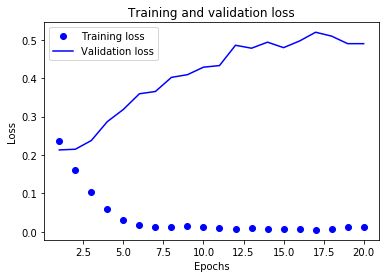

In [132]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

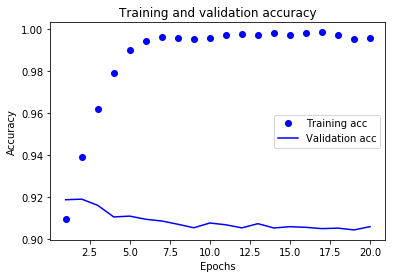

In [133]:
plt.clf()   # clear figure
history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [134]:
len([s.argmax() for s in y_prob if s.max()>.95])

9686

In [209]:
y_prob = model.predict(x_val)
y_classes = y_prob.argmax(axis=-1)
y_classes_prob=[s.max() for s in y_prob]

y_classes_val=y_val.argmax(axis=-1)

In [210]:
df_val=pd.DataFrame({'pred':y_classes, 
                     'true':y_classes_val, 
                     'prob':y_classes_prob})

len(df_val[df_val.pred==df_val.true])/len(df_val)

0.5756111111111111

In [211]:
df_95=df_val[df_val.prob>.95]

In [212]:
len(df_95[df_95.pred==df_95.true])/len(df_95)

0.9167043911272069

In [213]:
len(df_val[df_val.pred==df_val.true])

10361

In [214]:
df_val.pred.unique()

array([3, 4, 6, 0, 1, 8, 7, 2, 5])

In [215]:
len(df_train)

229472

In [216]:
len(trainDF)

60000

In [217]:
df_val.groupby('pred')[['prob']].describe()

prob                                                              \
       count      mean       std       min       25%       50%       75%   
pred                                                                       
0     2003.0  0.741038  0.226161  0.179195  0.553635  0.800109  0.957718   
1     3321.0  0.702909  0.214974  0.187883  0.518963  0.736724  0.901462   
2      385.0  0.707682  0.196514  0.227800  0.548713  0.721776  0.889960   
3     1577.0  0.660265  0.208047  0.196918  0.486272  0.667132  0.846662   
4     7764.0  0.685369  0.207416  0.132313  0.515284  0.694191  0.874676   
5       57.0  0.338724  0.112924  0.220680  0.266556  0.306376  0.369489   
6     2375.0  0.598226  0.192021  0.199413  0.445903  0.580828  0.746043   
7      236.0  0.603263  0.216469  0.192203  0.424609  0.594151  0.801677   
8      282.0  0.613142  0.214152  0.205274  0.430801  0.595048  0.762561   

                
           max  
pred            
0     0.999084  
1     0.992873  
2     0.996574  
3     0.994456  
4     0.999471  
5     0.789248  
6     0.993534  
7     0.990671  
8     0.999094

In [218]:
df_val.sample(20)

,pred,true,prob
17678,1,1,0.937727
12243,4,4,0.362340
5267,4,0,0.824200
2411,4,1,0.576921
9351,3,8,0.433261
10323,1,1,0.926592
8791,4,3,0.441266
9406,1,3,0.520562
7418,4,2,0.831384
3140,7,7,0.883136


In [219]:
df_95.pred.unique()

array([4, 0, 1, 3, 6, 8, 7, 2])